1. Load and Preprocess Dataset

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords

# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')

# Load Fake and True News Datasets
df_fake = pd.read_csv("Fake.csv")
df_fake["label"] = 1  # Assign label 1 for Fake News

df_true = pd.read_csv("True.csv")
df_true["label"] = 0  # Assign label 0 for Real News

# Combine both datasets
df = pd.concat([df_fake, df_true], ignore_index=True)

# Preprocessing Function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower())  # Remove non-alphabetic characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply preprocessing
df['clean_text'] = df['title'].apply(preprocess_text)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hanhuazhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hanhuazhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2. Train & Evaluate Traditional ML Models
2.1 TF-IDF + Support Vector Machine (SVM

In [2]:
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Predictions & Evaluation
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9407572383073497
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4247
           1       0.95      0.94      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



2.2 TF-IDF + Logistic Regression

In [3]:
# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predictions & Evaluation
y_pred_logreg = log_reg.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.9416481069042316
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4247
           1       0.95      0.94      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



3. Train & Evaluate Deep Learning Models 
3.1 LSTM

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  # ✅ Import TensorDataset and DataLoader
import numpy as np
import nltk

# Convert text to numerical tokens
tokenizer = nltk.word_tokenize
X_train_tokens = [tokenizer(text) for text in X_train]
X_test_tokens = [tokenizer(text) for text in X_test]

# Create word index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(set(sum(X_train_tokens, [])))}
X_train_indices = [[word2idx[word] for word in text if word in word2idx] for text in X_train_tokens]
X_test_indices = [[word2idx[word] for word in text if word in word2idx] for text in X_test_tokens]

# Pad sequences
max_len = 50
X_train_tensor = torch.tensor([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in X_train_indices])
X_test_tensor = torch.tensor([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in X_test_indices])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        return self.fc(lstm_out)

# Train LSTM Model
lstm_model = LSTMModel(len(word2idx) + 1, 50, 100, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)  # ✅ Now TensorDataset is defined

for epoch in range(5):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/var/folders/n6/y_4fsn553lq6_fzmfb11cjth0000gn/T/ipykernel_26700/378283389.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/torch/csrc/utils/tensor_new.cpp:248.)
  X_train_tensor = torch.tensor([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in X_train_indices])


Epoch 1, Loss: 0.6976
Epoch 2, Loss: 0.6965
Epoch 3, Loss: 0.6841
Epoch 4, Loss: 0.6946
Epoch 5, Loss: 0.6650


4. Transformer-Based Models (BERT, DistilBERT)
4.1 BERT for Fake News Detection

In [5]:
pip install --upgrade accelerate


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade transformers safetensors


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [5]:
rm -rf ~/.cache/huggingface/transformers


In [6]:
model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    from_tf=False  
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake["label"] = 0
df_true["label"] = 1
df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)


In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=512, return_tensors="pt"
)
test_encodings = tokenizer(
    list(test_texts), truncation=True, padding=True, max_length=512, return_tensors="pt"
)


In [9]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]
train_dataset = NewsDataset(train_encodings, train_labels.tolist())
test_dataset = NewsDataset(test_encodings, test_labels.tolist())


In [13]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]  
        return item


In [15]:
max_len = max([len(tokenizer.tokenize(txt)) for txt in train_texts])
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=max_len,  
    return_tensors="pt"
)


In [16]:
# Tokenize the test set
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=max_len,  # Use the same max length
    return_tensors="pt"
)


In [17]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]  # Add labels explicitly
        return item

# Convert tokenized data into dataset format
train_dataset = NewsDataset(train_encodings, train_labels.tolist())
test_dataset = NewsDataset(test_encodings, test_labels.tolist())


In [18]:
from transformers import BertForSequenceClassification

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="epoch"  # Evaluate at the end of each epoch
)


/Users/hanhuazhu/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,      
    padding="max_length", 
    max_length=512,        
    return_tensors="pt"
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
)



In [21]:
# Check the max length of tokenized text
max_train_len = max([len(tokenizer.tokenize(txt)) for txt in train_texts])
max_test_len = max([len(tokenizer.tokenize(txt)) for txt in test_texts])

print(f"Max token length in train set: {max_train_len}")
print(f"Max token length in test set: {max_test_len}")


Max token length in train set: 14283
Max token length in test set: 9163


In [22]:
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,         
    padding="max_length",    
    max_length=512,          
    return_tensors="pt"
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
)


In [36]:
max_train_len_after = max([len(x) for x in train_encodings["input_ids"]])
max_test_len_after = max([len(x) for x in test_encodings["input_ids"]])

print(f"Max token length in train set after truncation: {max_train_len_after}")
print(f"Max token length in test set after truncation: {max_test_len_after}")


Max token length in train set after truncation: 512
Max token length in test set after truncation: 512


In [23]:
import torch
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are tensors

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create dataset objects
train_dataset = NewsDataset(train_encodings, train_labels.tolist())
test_dataset = NewsDataset(test_encodings, test_labels.tolist())


In [24]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",       # Directory to save model checkpoints
    per_device_train_batch_size=8,   # Adjust based on available memory (reduce if out-of-memory error occurs)
    per_device_eval_batch_size=8,
    num_train_epochs=3,           # You can increase this for better accuracy
    logging_dir="./logs",         # Directory for logs
    evaluation_strategy="epoch"   # Evaluates at the end of each epoch
)


In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)


In [27]:
trainer.train()


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

LSTMModel

In [28]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  # ✅ Import TensorDataset and DataLoader
import numpy as np
import nltk

# Convert text to numerical tokens
tokenizer = nltk.word_tokenize
X_train_tokens = [tokenizer(text) for text in X_train]
X_test_tokens = [tokenizer(text) for text in X_test]

# Create word index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(set(sum(X_train_tokens, [])))}
X_train_indices = [[word2idx[word] for word in text if word in word2idx] for text in X_train_tokens]
X_test_indices = [[word2idx[word] for word in text if word in word2idx] for text in X_test_tokens]

# Pad sequences
max_len = 50
X_train_tensor = torch.tensor([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in X_train_indices])
X_test_tensor = torch.tensor([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in X_test_indices])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        return self.fc(lstm_out)

# Train LSTM Model
lstm_model = LSTMModel(len(word2idx) + 1, 50, 100, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)  # ✅ Now TensorDataset is defined

for epoch in range(5):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6945
Epoch 2, Loss: 0.6974
Epoch 3, Loss: 0.6818
Epoch 4, Loss: 0.6939
Epoch 5, Loss: 0.7101


5. Topic Modeling (LDA)

In [29]:
dictionary = Dictionary([preprocess_text(text).split() for text in X_train])
corpus = [dictionary.doc2bow(text.split()) for text in X_train]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
topics = lda_model.print_topics(num_words=5)

print("\nLDA Topics:")
for topic in topics:
    print(topic)


LDA Topics:
(0, '0.025*"video" + 0.025*"trump" + 0.012*"hillary" + 0.011*"clinton" + 0.007*"obama"')
(1, '0.035*"us" + 0.031*"trump" + 0.027*"says" + 0.018*"house" + 0.010*"white"')
(2, '0.006*"war" + 0.006*"syrian" + 0.006*"end" + 0.005*"air" + 0.005*"myanmar"')
(3, '0.053*"video" + 0.041*"trump" + 0.013*"watch" + 0.009*"news" + 0.008*"black"')
(4, '0.018*"trump" + 0.015*"court" + 0.014*"us" + 0.009*"new" + 0.007*"ban"')


6. Weakly Supervised Learning (Self-Training)

In [30]:
from sklearn.semi_supervised import SelfTrainingClassifier

self_training_model = SelfTrainingClassifier(base_estimator=LogisticRegression(), max_iter=10)
self_training_model.fit(X_train_tfidf, y_train)
self_training_acc = self_training_model.score(X_test_tfidf, y_test)
print(f"Weakly Supervised Learning Accuracy: {self_training_acc:.4f}")

/Users/hanhuazhu/.local/lib/python3.11/site-packages/sklearn/semi_supervised/_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Weakly Supervised Learning Accuracy: 0.9416


In [31]:
# Import necessary libraries
import nltk
from collections import Counter
from nltk.util import ngrams

# Ensure necessary NLTK resources are available
nltk.download('punkt')

# Tokenize text into words
def tokenize_text(text):
    return nltk.word_tokenize(text.lower())

# Function to extract n-grams (bi-grams and tri-grams)
def extract_ngrams(texts, n=2, top_n=10):
    all_ngrams = []
    for text in texts:
        tokens = tokenize_text(text)
        n_grams = list(ngrams(tokens, n))
        all_ngrams.extend(n_grams)
    
    # Count frequency of n-grams
    ngram_freq = Counter(all_ngrams)
    
    # Return top N most common n-grams
    return ngram_freq.most_common(top_n)

# Extract top bi-grams and tri-grams from fake news headlines
top_bigrams_fake = extract_ngrams(df_fake['title'], n=2, top_n=10)
top_trigrams_fake = extract_ngrams(df_fake['title'], n=3, top_n=10)

# Extract top bi-grams and tri-grams from real news headlines
top_bigrams_real = extract_ngrams(df_true['title'], n=2, top_n=10)
top_trigrams_real = extract_ngrams(df_true['title'], n=3, top_n=10)

# Display results
print("\nTop Bi-grams in Fake News Headlines:", top_bigrams_fake)
print("\nTop Tri-grams in Fake News Headlines:", top_trigrams_fake)
print("\nTop Bi-grams in Real News Headlines:", top_bigrams_real)
print("\nTop Tri-grams in Real News Headlines:", top_trigrams_real)

[nltk_data] Downloading package punkt to /Users/hanhuazhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Top Bi-grams in Fake News Headlines: [(('’', 's'), 7152), (('video', ']'), 5136), (('[', 'video'), 5124), (('video', ')'), 2560), (('(', 'video'), 2555), ((':', '“'), 1581), (('’', 't'), 1563), (('trump', '’'), 1494), (('watch', ':'), 1214), (('”', '['), 1178)]

Top Tri-grams in Fake News Headlines: [(('[', 'video', ']'), 5120), (('(', 'video', ')'), 2553), (('trump', '’', 's'), 1456), (('”', '[', 'video'), 1164), (('obama', '’', 's'), 668), (('it', '’', 's'), 510), (('(', 'tweets', ')'), 430), (('hillary', '’', 's'), 418), (('he', '’', 's'), 358), (('won', '’', 't'), 320)]

Top Bi-grams in Real News Headlines: [(('white', 'house'), 783), (('north', 'korea'), 716), (('trump', "'s"), 670), (('factbox', ':'), 409), (('trump', 'says'), 355), (('trump', 'to'), 309), ((':', 'white'), 269), ((':', 'trump'), 247), (('islamic', 'state'), 242), (('trump', ','), 238)]

Top Tri-grams in Real News Headlines: [((':', 'white', 'house'), 269), (('on', 'north', 'korea'), 136), (('factbox', ':', 'trum

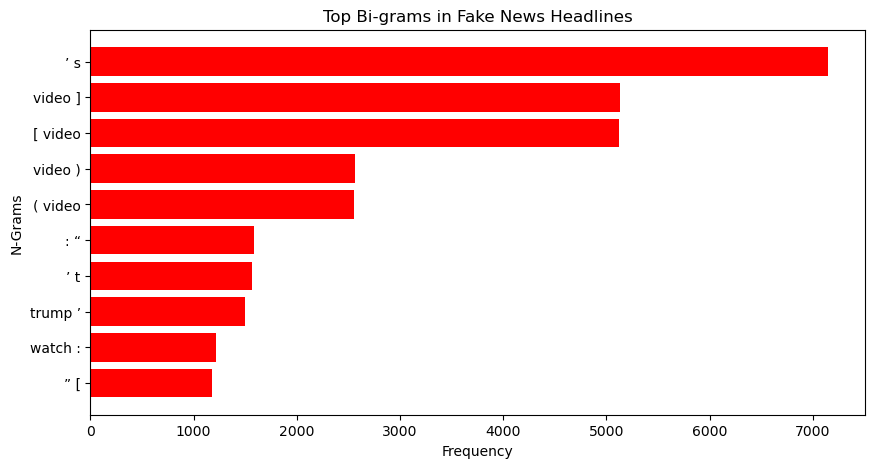

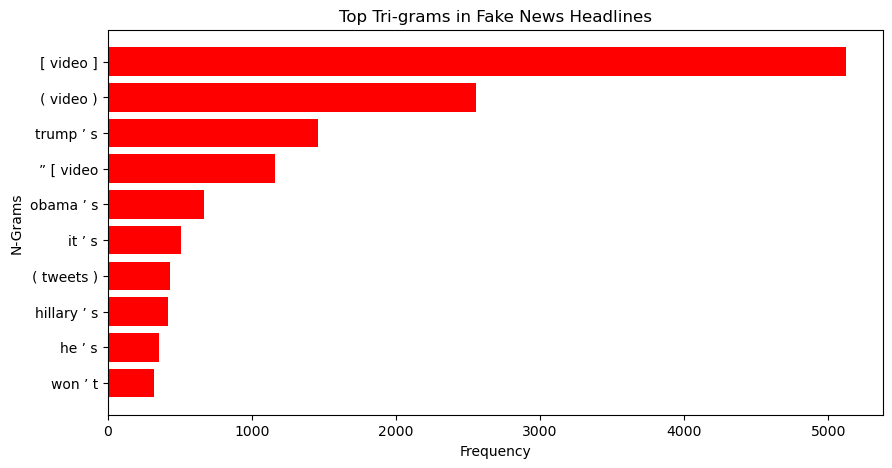

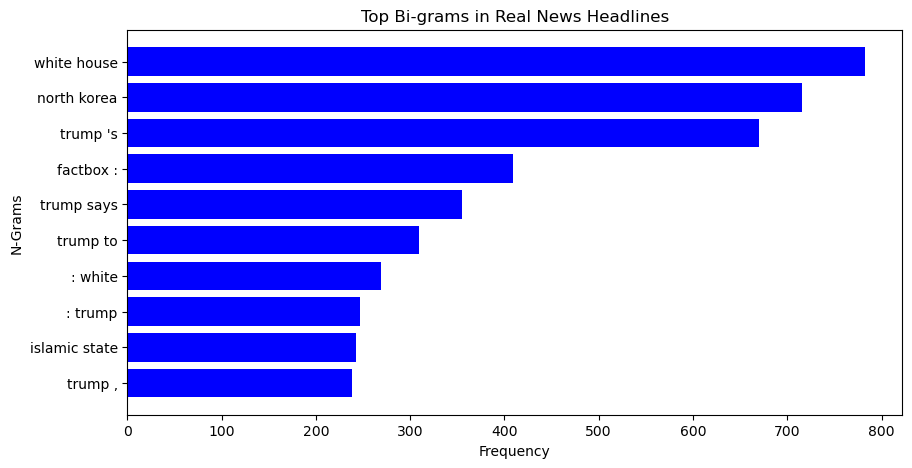

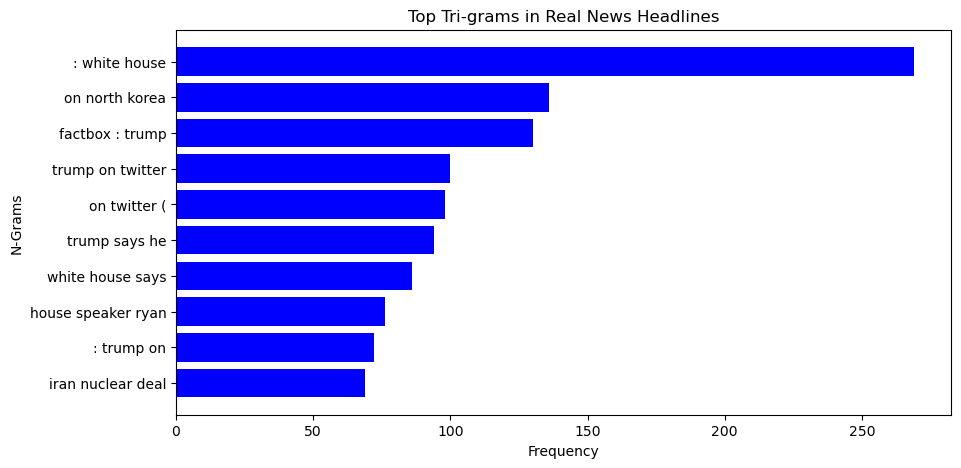

In [32]:
import matplotlib.pyplot as plt

# Function to plot n-grams
def plot_ngrams(ngram_list, title, color='blue'):
    ngrams, counts = zip(*ngram_list)  # Unpack tuples
    ngrams = [' '.join(gram) for gram in ngrams]  # Convert tuples to strings

    plt.figure(figsize=(10, 5))
    plt.barh(ngrams[::-1], counts[::-1], color=color)  # Reverse order for better visualization
    plt.xlabel("Frequency")
    plt.ylabel("N-Grams")
    plt.title(title)
    plt.show()

# 🔹 Plot Fake News N-Grams
plot_ngrams(top_bigrams_fake, "Top Bi-grams in Fake News Headlines", color="red")
plot_ngrams(top_trigrams_fake, "Top Tri-grams in Fake News Headlines", color="red")

# 🔹 Plot Real News N-Grams
plot_ngrams(top_bigrams_real, "Top Bi-grams in Real News Headlines", color="blue")
plot_ngrams(top_trigrams_real, "Top Tri-grams in Real News Headlines", color="blue")


In [35]:
import pandas as pd

# Convert n-grams into DataFrames for side-by-side comparison
df_ngrams = pd.DataFrame({
    "Fake News Bi-grams": [' '.join(gram) for gram, _ in top_bigrams_fake],
    "Fake News Bi-gram Count": [count for _, count in top_bigrams_fake],
    "Real News Bi-grams": [' '.join(gram) for gram, _ in top_bigrams_real],
    "Real News Bi-gram Count": [count for _, count in top_bigrams_real],
    "Fake News Tri-grams": [' '.join(gram) for gram, _ in top_trigrams_fake],
    "Fake News Tri-gram Count": [count for _, count in top_trigrams_fake],
    "Real News Tri-grams": [' '.join(gram) for gram, _ in top_trigrams_real],
    "Real News Tri-gram Count": [count for _, count in top_trigrams_real]
})

# Display DataFrame using Pandas
print(df_ngrams)

# If using Jupyter Notebook, display it nicely
from IPython.display import display
display(df_ngrams)



  Fake News Bi-grams  Fake News Bi-gram Count Real News Bi-grams  \
0                ’ s                     7152        white house   
1            video ]                     5136        north korea   
2            [ video                     5124           trump 's   
3            video )                     2560          factbox :   
4            ( video                     2555         trump says   
5                : “                     1581           trump to   
6                ’ t                     1563            : white   
7            trump ’                     1494            : trump   
8            watch :                     1214      islamic state   
9                ” [                     1178            trump ,   

   Real News Bi-gram Count Fake News Tri-grams  Fake News Tri-gram Count  \
0                      783           [ video ]                      5120   
1                      716           ( video )                      2553   
2                      

,Fake News Bi-grams,Fake News Bi-gram Count,Real News Bi-grams,Real News Bi-gram Count,Fake News Tri-grams,Fake News Tri-gram Count,Real News Tri-grams,Real News Tri-gram Count
0,’ s,7152,white house,783,[ video ],5120,: white house,269
1,video ],5136,north korea,716,( video ),2553,on north korea,136
2,[ video,5124,trump 's,670,trump ’ s,1456,factbox : trump,130
3,video ),2560,factbox :,409,” [ video,1164,trump on twitter,100
4,( video,2555,trump says,355,obama ’ s,668,on twitter (,98
5,: “,1581,trump to,309,it ’ s,510,trump says he,94
6,’ t,1563,: white,269,( tweets ),430,white house says,86
7,trump ’,1494,: trump,247,hillary ’ s,418,house speaker ryan,76
8,watch :,1214,islamic state,242,he ’ s,358,: trump on,72
9,” [,1178,"trump ,",238,won ’ t,320,iran nuclear deal,69


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Combine fake and real news headlines
df_fake["label"] = 0  # Fake news label = 0
df_true["label"] = 1  # Real news label = 1
df_combined = pd.concat([df_fake, df_true]).reset_index(drop=True)

# Extract headlines and labels
X = df_combined["title"]
y = df_combined["label"]

# Convert headlines into n-gram TF-IDF features
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)  # Use bi-grams & tri-grams
X_tfidf = vectorizer.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Print classification results
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4733
           1       0.85      0.90      0.88      4247

    accuracy                           0.88      8980
   macro avg       0.88      0.88      0.88      8980
weighted avg       0.88      0.88      0.88      8980

